For each product image, I would like you to do the following. The output of this task will have the following variables for each image and append them to 
Read the image files and for each handbag image, find the below features and append it to ProductInfo.csv
1.	Logo size (logoSize)
2.	Logo contrast (logoConst)
3.	Logo conspicuousness (logoConsp)
4.	Number of colors (numColors)
5.	Color Entropy (ColorEnt)  


In [1]:
# Connecting to Google Cloud

from google.cloud import vision
from google.oauth2 import service_account

creds = service_account.Credentials.from_service_account_file('My First Project-c1dd0c0c9fd5.json')


In [14]:
import os
import io
import pandas as pd
import numpy as np
import cv2
import math
from math import log, e
import random
from PIL import Image as Img
from IPython.display import Image
import webcolors
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from collections import Counter, defaultdict

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
def crop_image(img, img_path):
    '''
    This function takes a PIL image as an input and the image in bytes, detects handbag and returns the vertices of the handbag
    Input : PIL imaage and image in bytes
    Output : cropped handbag and its size
    
    content = cv2.imencode('.png', np.array(img))[1].tobytes()
    image = vision.Image(content=content) (converting pil to numpy detects very less logos)
    image = vision.Image(content=img_bytes) # directly using img bytes (doesn't detect all logos)
    '''

    with io.open(img_path, 'rb') as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
          
    height, width = img.size

    objects = client.object_localization(image=image).localized_object_annotations

    cropped_imgs = []
    for object_ in objects:
        if object_.name =='Bag' or object_.name == 'handbag':
            vects = object_.bounding_poly.normalized_vertices
            
            x0, x2 = vects[0].x, vects[2].x
            x0, x2 = x0*width, x2*width
            y0, y2 = vects[0].y, vects[2].y
            y0, y2 = y0*height, y2*height
            
            vects = [x0, y0, x2-1, y2-1]
            
            crop_img = img.crop(vects)
            cropped_imgs.append(crop_img)
    
    if len(cropped_imgs) > 0:
        cropped_imgs[0].save('cropped.jpg')
        return cropped_imgs[0]
    else:
        img.save('cropped.jpg')
        return img


def get_logo(bag_img, img_path):
    '''
     This functions takes cropped handbag image in PIL format, detects logo and returns the cropped logo
     Input: Cropped handbag image in PIL
     Output: Cropped logo and its size if logo exists else None, 0
     
     #content = cv2.imencode('.png', np.array(bag_img))[1].tobytes()
     #image = vision.Image(content=content)
     #image = vision.Image(content=cropped_img_bytes)
    '''
    
    with io.open(img_path, 'rb') as image_file:
        content = image_file.read()
    image = vision.Image(content=content)
        
    # Detects logo and returns the size of the logo and vertices  
    response = client.logo_detection(image=image)
    annotations = response.logo_annotations
    #print("Annotations  in logo vertices func : ", annotations)
    if len(annotations) != 0:
        for annotation in annotations:
            vects = annotation.bounding_poly.vertices
            #print(vects)
    else:
        vects = []
        
    if len(vects) > 0: 
        cropped_logo = bag_img.crop([vects[0].x, vects[0].y, vects[2].x - 1, vects[2].y - 1]) 
        #Img.fromarray(np.array(cropped_logo)).show()
        #print("Logo found")
        return cropped_logo
    else:
        return None
        
    

def closest_color(requested_color):
    '''
     This functions takes a color in rgb and returns the color that closely resembles to that color
     Input: Color
     Output: color closest to the minimum color
    '''

    min_colors = {}
    for key, name in webcolors.css21_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_color[0]) ** 2
        gd = (g_c - requested_color[1]) ** 2
        bd = (b_c - requested_color[2]) ** 2
        min_colors[(rd + gd + bd)] = name
        
    return min_colors[min(min_colors.keys())]



def get_color_name(requested_color):
    '''
     This functions takes a color in rgb and returns the name of the color.
     Input: Color
     Output: Name of the color
    '''

    try:
        actual_name = webcolors.rgb_to_name(requested_color)
    except ValueError:
        closest_name = closest_color(requested_color)
        actual_name = None
        
    return actual_name, closest_name


def centroid_histogram(clt):
    '''
     This functions takes the labels from the kmeans model and creates a histogram
     Input: fitted model
     Output: creates a histogram of all the colors based on labels
    '''
    # grab the number of different clusters based on the number of pixels assigned to each cluster

    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    
    return hist



def get_most_dominant_color(bar):
    '''
     This functions takes all the colors and returns the most dominant color, ratio and rgb_color
     Input: all the colors
     Output: Most dominant color with its ratio and rgb value
    '''

    dominant_color = "black"
    max_ratio = 0

    for colors in bar:
        if colors[1] > max_ratio:
            max_ratio = colors[1]
            dominant_color = colors[0]
            rgb_color = colors[2]
        
    return dominant_color, max_ratio, rgb_color  



def get_sorted_colors(all_colors):
    '''
     This functions takes all the colors which can be duplicate and returns the list of unique colors in
     decending order based on their total ratio
     Input: all the colors
     Output: list of unoque colors in decending order
    '''
    
    color_pixels = {}

    for color in all_colors:
        if color[0] not in color_pixels:
            color_pixels[color[0]] = color[1]
        else:
            color_pixels[color[0]] += color[1]

    sorted_colors_pixels = sorted(color_pixels.items(), key=lambda x: x[1], reverse=True) 
    
    return sorted_colors_pixels



def get_colors(hist, centroids):
    '''
     This functions takes the histogram and labels and returns dominant color, it's ratio, rgb value and all colors
     Input: histogram and labels
     Output: dominant_color, ratio, rgb_color, all_colors
    '''
    
    # initialize the bar chart representing the relative frequency of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
    all_colors = []
    
    # loop over the percentage and color of each cluster
    for (percent, color) in zip(hist, centroids):
        requested_color = color.astype(int)
        
        actual_name, closest_name = get_color_name(requested_color)
        
        if actual_name is None:
            all_colors.append([closest_name, percent, requested_color])
        else:
            all_colors.append([actual_name, percent, requested_color])
            
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50), color.astype("uint8").tolist(), -1)
        startX = endX
         
    dominant_color, ratio, rgb_color = get_most_dominant_color(all_colors)

    return bar, dominant_color, ratio, rgb_color, all_colors



def mean_image(image, segments):
    '''
    This function takes segmented image and number of segments as input and returns the image with
    average of superpixels
    Input: Segmented Image, No of segments
    Output: Image with average of colors in superpixels
    '''

    reshaped_image = image.reshape((image.shape[0]*image.shape[1], image.shape[2]))
    segment_1d = np.reshape(segments, -1)    
    unique_segment = np.unique(segment_1d)
    img_shape = np.zeros(reshaped_image.shape)
    
    for i in unique_segment:
        loc = np.where(segment_1d==i)[0]
        img_mean = np.mean(reshaped_image[loc,:], axis=0)
        img_shape[loc,:] = img_mean
        
    out_img = np.reshape(img_shape,[image.shape[0], image.shape[1], image.shape[2]]).astype('uint8')
    
    return out_img 
    


def segment_image(cropped_img, numSegments):
    '''
    Segements the cropped image as input and no of segments and convert it into superpixels
    Input: Cropped Image, Number of segments
    Output: Segmented image and image with average of colors in superpixels
    '''

    converted_img = img_as_float(cropped_img[:,:,::-1]) #convert it to a floating point data type
    segments = slic(converted_img, n_segments=numSegments, compactness=10, sigma=5, convert2lab=True)
    
    # Average the color in each superpixel.
    out_img = mean_image(cropped_img, segments)
    
    return out_img



def is_white_pixel(x):
    x = x.tolist()
    if x[0]==x[1]==x[2]==255:
        return False
    return True


def segment_and_cluster(num_segments, cropped_img, cluster_size):
    '''
    This function segments the image, cluster the pixels using kmeans clustering and return the complete details of colors
    Input: number of segments to be done, cropped image, cluster size
    Output: bar, dominant_color, ratio, rgb_color, all_colors
    '''
    
    # Segmentation of the image into superpixels and taking average of superpixels
    out_img = segment_image(cropped_img, num_segments)
    
    # Removing the white background before clustering
    reshaped_img = out_img.reshape((-1,3))
    mask = np.apply_along_axis(is_white_pixel, 1, reshaped_img)
    white_removed = reshaped_img[mask]
    
    # cluster the pixel intensities   
    clt = KMeans(n_clusters = cluster_size, random_state=42)
    clt.fit(white_removed)
    #clt.fit(filtered_img.reshape(-1,3))
    

    hist = centroid_histogram(clt)   
    bar, dominant_color, ratio, rgb_color, all_colors = get_colors(hist, clt.cluster_centers_)
    
    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.show()
    
    
    return bar, dominant_color, ratio, rgb_color, all_colors
   
    
    
def calculate_luminace(color_code):
    '''
    This function calculates the luminance of color
    Input: a color code in rgb
    Output: luminance
    '''
    
    index = float(color_code)/255 

    if index < 0.03928:
        return index / 12.92
    else:
        return ((index + 0.055) / 1.055)**2.4
    

    
def calculate_relative_luminance(rgb):
    '''
    This function calculates the relative luminance of the color using the 3 channels of R, G, B
    Input: a color in rgb
    Output: relative luminance
    '''
    
    return 0.2126*calculate_luminace(rgb[0]) + 0.7152*calculate_luminace(rgb[1]) + 0.0722*calculate_luminace(rgb[2])
    



Total sellers :  114


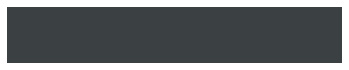

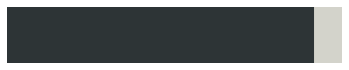

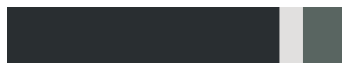

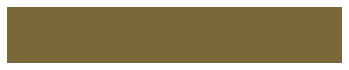

Color result dict :  {1: [('teal', 1.0)], 2: [('black', 0.9171119089081161), ('silver', 0.08288809109188384)], 3: [('black', 0.816510746295227), ('gray', 0.11596458755086717), ('white', 0.06752466615390584)]}
k2_dominant_ratio :  0.9171119089081161
Total colors are :  1
Entropy of handbag is :  0


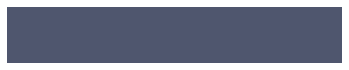

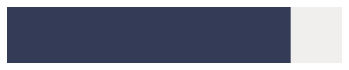

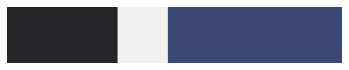

Color result dict :  {1: [('gray', 1.0)], 2: [('navy', 0.84867190672137), ('white', 0.15132809327862992)], 3: [('teal', 0.5192259909945398), ('black', 0.3310494451885026), ('white', 0.14972456381695765)]}
k2_dominant_ratio :  0.84867190672137
Total colors are :  2
Entropy of handbag is :  0.6131539036385149


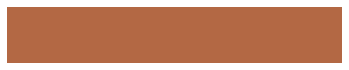

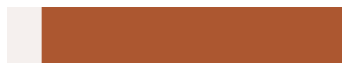

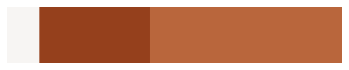

Color result dict :  {1: [('gray', 1.0)], 2: [('olive', 0.8950738150738151), ('white', 0.10492618492618493)], 3: [('olive', 0.9007595182595183), ('white', 0.09924048174048174)]}
k2_dominant_ratio :  0.8950738150738151
Total colors are :  2
Entropy of handbag is :  0.4844194987198679


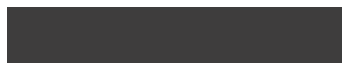

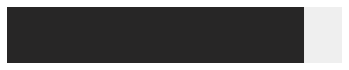

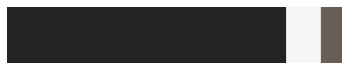

Color result dict :  {1: [('black', 1.0)], 2: [('black', 0.8870406740862471), ('white', 0.11295932591375295)], 3: [('black', 0.8363105179009624), ('white', 0.10358798615842986), ('gray', 0.06010149594060773)]}
k2_dominant_ratio :  0.8870406740862471
Total colors are :  2
Entropy of handbag is :  0.5087781507068535


KeyboardInterrupt: 

In [19]:
def process_images(img_path):
    
    if not os.path.isfile(img_path):
        return pd.Series([None]*5)
    
    # Get the cropped bag
    img = Img.open(img_path)
    cropped_bag = crop_image(img, img_path) 
    height, width = cropped_bag.size
    bag_size = height*width
    #print("Bag size : ", bag_size)
    #Img.fromarray(np.array(cropped_bag)).show()
    
    # Get the cropped logo
    cropped_img_path = 'cropped.jpg'
    cropped_img = Img.open(cropped_img_path)
    cropped_logo= get_logo(cropped_img, cropped_img_path) 
    

    # converting cropped bag img from PIL to numpy array
    cropped_bag = np.array(cropped_bag)
    

    # Segmentation of the image into superpixels, taking average of superpixels and then doing clustering
    num_segments = 600
    cluster_size = 4

    color_result = {}
    rgb_colors = []
    for i in range(1, cluster_size):
        # print("Processing for bag")
        bar, bag_dominant_color, bag_ratio, bag_rgb, all_bag_colors = segment_and_cluster(num_segments, cropped_bag, i)
        sorted_bag_colors = get_sorted_colors(all_bag_colors)
        color_result[i] = sorted_bag_colors
        rgb_colors.append(bag_rgb)


    #print("Processing for logo")
    
    if cropped_logo is not None:
        cropped_logo = np.array(cropped_logo)  # converting pil image to numpy array
        num_segments = 300
        cluster_size = 1

        # Get logo size 
        height, width, _ = cropped_logo.shape
        logo_size = height * width
        #print("Logo size : ", logo_size)        
        
        bar, logo_dominant_color, logo_ratio, logo_rgb, all_logo_colors = segment_and_cluster(num_segments, cropped_logo, cluster_size)
        sorted_logo_colors = get_sorted_colors(all_logo_colors)
        #print("logo colors : ", sorted_logo_colors)

        # Calculate contrast ratio of logo to bag
        contrast_ratio = (calculate_relative_luminance(logo_rgb)+0.05) / (calculate_relative_luminance(bag_rgb)+0.05)
        #print("Contrast ratio is : ", contrast_ratio)
        
        # Calculate Logo Conspicuousness
        relative_size = logo_size/bag_size
        logo_conspicuousness = contrast_ratio * relative_size
        #print("Logo Conspicuousness : ", logo_conspicuousness)

    else:
        logo_size = 0.0
        contrast_ratio = 0.0
        logo_conspicuousness = 0.0
        
        

    # Find total number of colors and entropy of the bag

    print("Color result dict : ", color_result)
    k2 = color_result[2]
    k3 = color_result[3]
    k2_dominant_ratio = k2[0][1]
    print("k2_dominant_ratio : ", k2_dominant_ratio)
    if k2_dominant_ratio >= 0.9:
        total_colors = 1
        entropy = 0
    elif k2_dominant_ratio < 0.9 and k2_dominant_ratio >= 0.6:
        total_colors = 2
        entropy = -1 * ((k2_dominant_ratio * log(k2_dominant_ratio, 2)) + (k2[1][1] * log(k2[1][1], 2)))
    else:
        total_colors = 3
        entropy = -1 * ((k3[0][1] * log(k3[0][1], 2) + (k3[1][1] * log(k3[1][1], 2)) +
                       (k3[2][1] * log(k3[2][1], 2))))
                
    print("Total colors are : ", total_colors)
    print("Entropy of handbag is : ", entropy)
    
    return_output = (logo_size,
                     round(contrast_ratio, 3),
                     round(logo_conspicuousness, 3),
                     total_colors, round(entropy, 3))

    for i in range(1, 4):
        colors, ratios = list(zip(*color_result[i]))
        ratios = [round(val, 2) for val in ratios]
        return_output = return_output + (colors, ratios)

    return pd.Series(return_output)


def read_images(dir_path, client):
    count = 0
    
    item_details = pd.DataFrame(columns = ['Seller', 'Item ID', 'category', 'brand', 'color', 'Image_path']) 
    dir_names = os.listdir(dir_path)
    print("Total sellers : ", len(dir_names))
    for seller in dir_names:
        if not seller.startswith('seller_'):
            continue
        
        product_info = pd.read_csv(dir_path+seller+'/ProductInfo.csv', usecols=["Item ID", "category", "brand", "color"])
        product_info['Seller'] = seller

        
        # Get the image names and add to the dataframe
        product_info['Image_path'] = ''
        img_fnames = os.listdir(dir_path + seller + '/Images')
        for idx in range(len(img_fnames)):
            img_path = dir_path + seller + '/Images/' + img_fnames[idx]
            img_id = int(img_fnames[idx].split('-')[0])
            img_fnames[idx] =  [img_path, img_id]
        
        img_ids, img_names = map(list, zip(*img_fnames))
        product_info['Image_path'] = product_info['Item ID'].replace(to_replace=img_names, value=img_ids)
        
        item_details = pd.concat([item_details, product_info], ignore_index=True)
        
    
    # Removing the rows that doesn't contain bags
    item_details = item_details[item_details['category'].str.match('Bags')]
    
    #import ipdb; ipdb.set_trace()
    
    new_cols = ['Logo Size', 'Logo Contrast', 'Logo Conspicuousness', 'Number of colors', 'Color Entropy']
    for col in new_cols:
        item_details[col] = None
    
        
    item_details[new_cols] = item_details['Image_path'].apply(process_images)
    
    return item_details

client = vision.ImageAnnotatorClient(credentials=creds)
product_info = read_images('Group4/Sellers/', client) #seller_105548/Images')
product_info

In [15]:
product_info.to_csv("bag_details.csv")

### Getting unique handbag brands:

In [15]:
bags = pd.read_csv("bag_details_v1.csv")
bag_brands = bags['brand']
bag_brands.value_counts().to_csv("bag_brands.csv")